In [3]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from utils.load_dataset import load_dataset

tf.get_logger().setLevel(logging.ERROR)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Загрузим данные, разбив на тренировочную, валидационную и тестовую выборки:

In [5]:
train_ds, val_ds, test_ds = load_dataset(os.path.abspath('images'))

Found 19794 files belonging to 40 classes.
Using 13856 files for training.
Found 19794 files belonging to 40 classes.
Using 5938 files for validation.


Загрузим базовую модель InceptionV3 без верхних слоев:

In [6]:
base_model = tf.keras.applications.InceptionV3(input_shape=(256, 256, 3),
                                               include_top=False,
                                               weights='imagenet')

Заморозим слои, чтобы веса не обновлялись во время обучения:

In [7]:
base_model.trainable = False

Определим архитектуру нашей модели:

In [8]:
inputs = tf.keras.Input(shape=(256, 256, 3))
preprocess =  tf.keras.layers.Rescaling(1./255)(inputs)
x = base_model(preprocess, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(40, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                             

Начнем обучение модели с замороженными нижними слоями:

In [10]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

Определим наши коллбэк-функции:

In [11]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoints/inception_v3.weights.h5",
    save_weights_only=True)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [12]:
%%time
history_1 = model.fit(train_ds,
                      epochs=20,
                      validation_data=val_ds,
                      callbacks=[checkpoint_cb, es])

Epoch 1/20


2024-04-24 16:29:41.344237: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-24 16:29:41.591902: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 16:29:45.887381: I external/local_xla/xla/service/service.cc:168] XLA service 0x7be914b6d970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 16:29:45.887459: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-04-24 16:29:45.906536: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713950985.984504  117061 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


433/433 [==============================] - 58s 116ms/step - loss: 2.6298 - accuracy: 0.2998 - val_loss: 1.8934 - val_accuracy: 0.4848
Epoch 2/20
433/433 [==============================] - 47s 108ms/step - loss: 1.8016 - accuracy: 0.4880 - val_loss: 1.5872 - val_accuracy: 0.5550
Epoch 3/20
433/433 [==============================] - 47s 109ms/step - loss: 1.5594 - accuracy: 0.5561 - val_loss: 1.4553 - val_accuracy: 0.5810
Epoch 4/20
433/433 [==============================] - 47s 108ms/step - loss: 1.4060 - accuracy: 0.5933 - val_loss: 1.3672 - val_accuracy: 0.6131
Epoch 5/20
433/433 [==============================] - 47s 108ms/step - loss: 1.3029 - accuracy: 0.6228 - val_loss: 1.3034 - val_accuracy: 0.6286
Epoch 6/20
433/433 [==============================] - 47s 109ms/step - loss: 1.2083 - accuracy: 0.6486 - val_loss: 1.2503 - val_accuracy: 0.6448
Epoch 7/20
433/433 [==============================] - 47s 108ms/step - loss: 1.1424 - accuracy: 0.6679 - val_loss: 1.2343 - val_accuracy: 0.6

Так как число параметров в нижних слоях огромно (более 21 миллиона), то мы не будем размораживать \
нижние слои для тренировки в силу ограниченных вычислительных мощностей.

In [13]:
results = model.evaluate(test_ds)

93/93 [==============================] - 8s 82ms/step - loss: 1.1371 - accuracy: 0.6757


In [14]:
results

[1.1371382474899292, 0.6757392287254333]

Посомтрим несколько предсказаний:

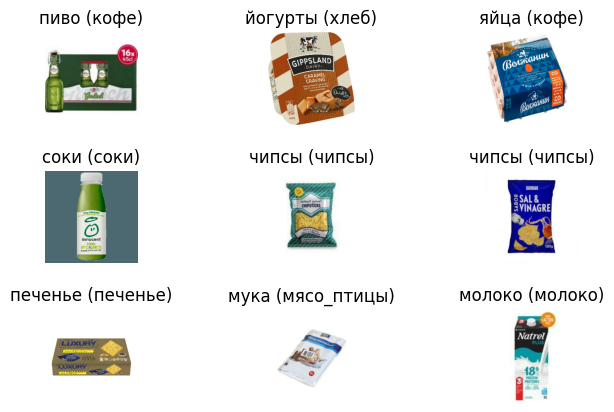

In [20]:
class_names = train_ds.class_names
IMAGE_NUM = 2
for i, (images, labels) in enumerate(test_ds):
    if i == 9:
        break
    ax = plt.subplot(3, 3, i + 1)
    im = np.expand_dims(images[IMAGE_NUM].numpy(), axis=0)
    prediction = class_names[np.argmax(model.predict(im, verbose=0)[0])]
    plt.imshow(images[IMAGE_NUM, ...].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels.numpy()[IMAGE_NUM])] + f' ({prediction})')
    plt.axis("off")
    plt.subplots_adjust(left=None, bottom=None, right=1.1, top=None, wspace=None, hspace=0.5)


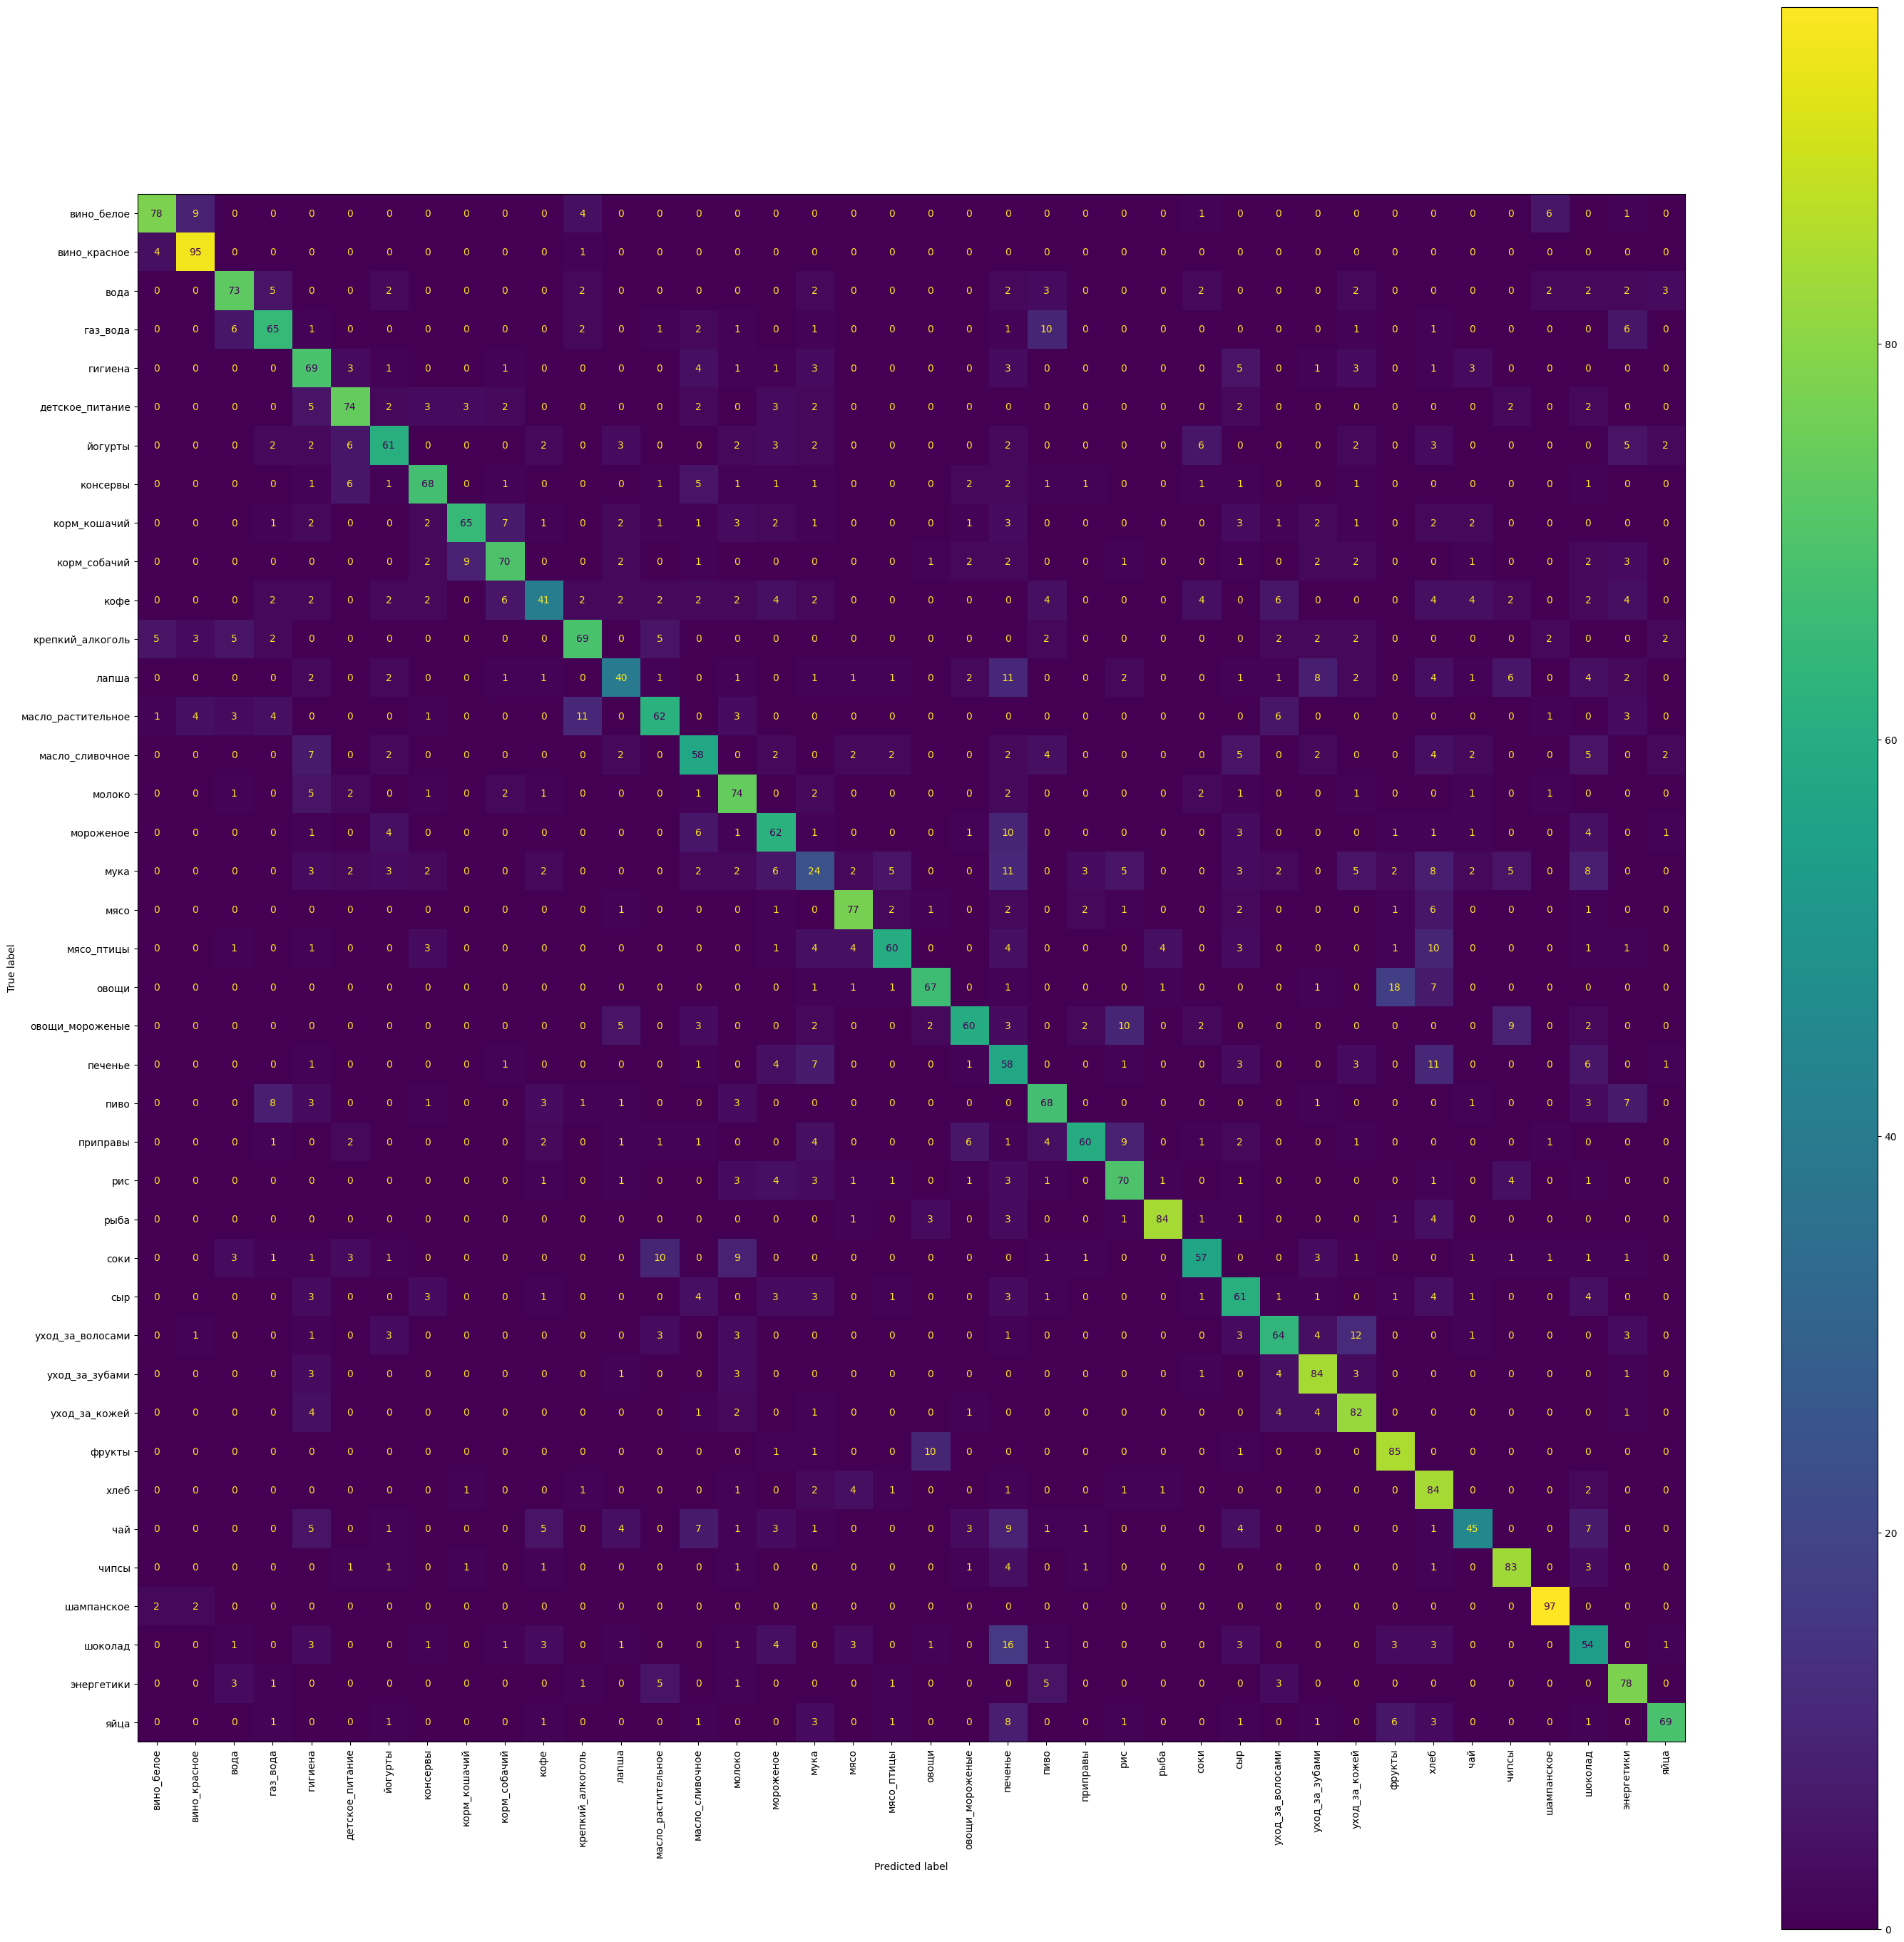

In [16]:
from utils.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(model, test_ds, train_ds.class_names)

In [17]:
model.save('ready_models/inception_v3.keras')

In [18]:
import json

with open('models_histories/inception_v3.json', 'w') as f:
    json.dump(history_1.history, f, indent=4)

Text(0, 0.5, 'Валидационная точность')

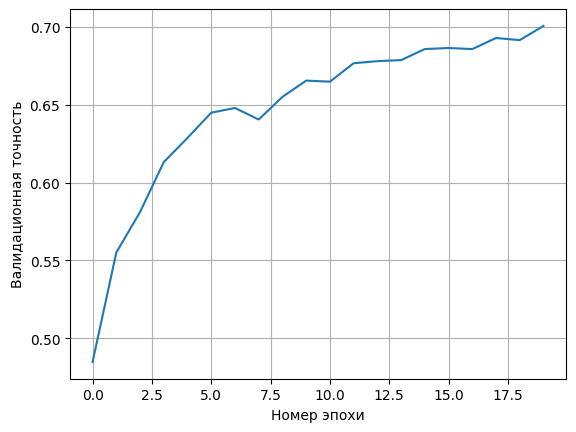

In [19]:
plt.plot(range(len(history_1.history['accuracy'])), history_1.history['val_accuracy'])
plt.grid()
plt.xlabel('Номер эпохи')
plt.ylabel('Валидационная точность')